## Setup

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

csv_path = "../database/seed.csv"

try:
    df = pd.read_csv(csv_path)
    print("Dataset carregado com sucesso!")
except FileNotFoundError:
    print(f"Arquivo não encontrado no caminho: {csv_path}")
except Exception as e:
    print(f"Erro ao carregar o dataset: {e}")


Dataset carregado com sucesso!


In [5]:
print(f"Número de linhas: {df.shape[0]}")
print(f"Número de colunas: {df.shape[1]}")
print("\nColunas do dataset:")
print(df.columns)


print("\nPrimeiras 5 linhas do dataset:")
print(df.head())


print("\nTipos de dados e valores ausentes:")
print(df.info())
print("\nValores ausentes por coluna:")
print(df.isnull().sum())

valores_unicos = df['type'].unique()
print("Valores únicos na coluna 'type':", valores_unicos)


Número de linhas: 3521
Número de colunas: 9

Colunas do dataset:
Index(['id', 'date', 'type', 'description', 'payment_method', 'bank', 'value',
       'categories', 'notes'],
      dtype='object')

Primeiras 5 linhas do dataset:
   id        date     type                                        description  \
0   1  2024-01-02  CREDITO                       CRED PIX HORFRAN - NF-e 4453   
1   2  2024-01-03  CREDITO  CRED TED BRASANITAS HOSPITALAR HIGIEN - NFS-e ...   
2   3  2024-01-05   DEBITO                ENVIO TEV ROBSON - PAGTO DE SALÁRIO   
3   4  2024-01-05   DEBITO                ENVIO PIX BRENDA - PAGTO DE SALÁRIO   
4   5  2024-01-05   DEBITO               ENVIO PIX CINTHYA - PAGTO DE SALÁRIO   

  payment_method   bank    value                             categories notes  
0            PIX  CAIXA   260.00  Recebimento, Pagamento de Nota Fiscal   NaN  
1  TRANSFERENCIA  CAIXA   585.00     Recebimento, Serviços Hospitalares   NaN  
2  TRANSFERENCIA  CAIXA  2145.47            

## Exploração

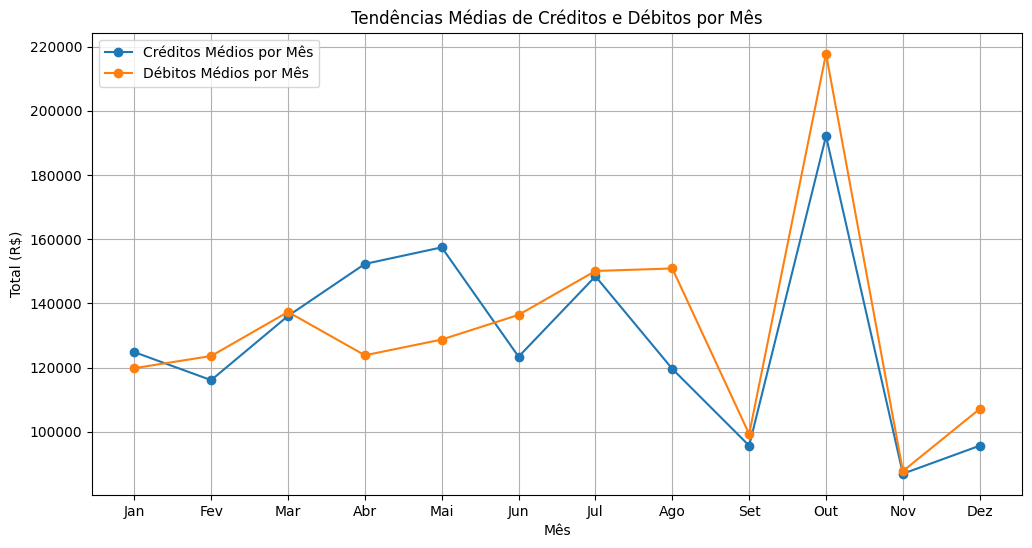

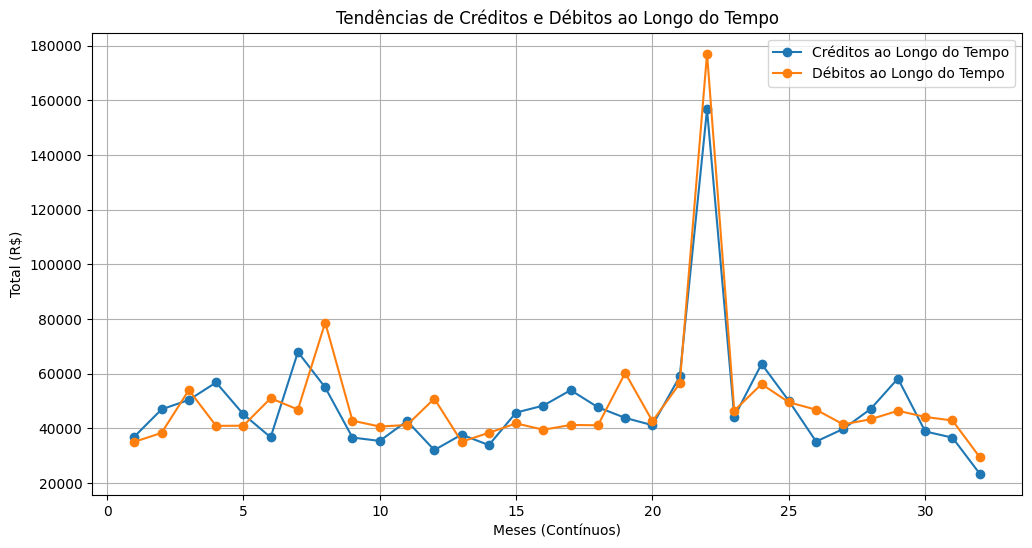

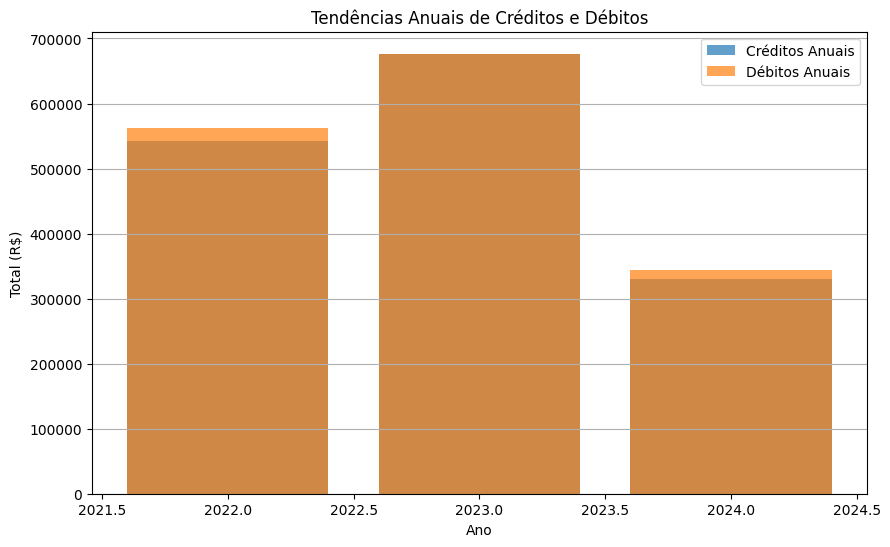

In [7]:
# Separar dados de crédito e débito
credito = df[df['type'] == 'CREDITO']
debito = df[df['type'] == 'DEBITO']

# Garantir que a coluna 'date' esteja no formato datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Extrair o mês e o ano para facilitar análises
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Função para agregar e renomear colunas
def agrupar_por_mes(data, col_valor, novo_nome):
    agregados = data.groupby('month')[col_valor].sum().reset_index()
    agregados.rename(columns={col_valor: novo_nome}, inplace=True)
    return agregados

# Agregar valores por mês
credito_por_mes = agrupar_por_mes(credito, 'value', 'total_credito')
debito_por_mes = agrupar_por_mes(debito, 'value', 'total_debito')

# Plotar tendências médias por mês do ano
plt.figure(figsize=(12, 6))
plt.plot(credito_por_mes['month'], credito_por_mes['total_credito'], label='Créditos Médios por Mês', marker='o')
plt.plot(debito_por_mes['month'], debito_por_mes['total_debito'], label='Débitos Médios por Mês', marker='o')
plt.title('Tendências Médias de Créditos e Débitos por Mês')
plt.xlabel('Mês')
plt.ylabel('Total (R$)')
plt.xticks(range(1, 13), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
plt.legend()
plt.grid()
plt.show()

# Agregar valores por ano e mês
def agrupar_por_tempo(data, col_valor, novo_nome):
    agregados = data.groupby(['year', 'month'])[col_valor].sum().reset_index()
    agregados.rename(columns={col_valor: novo_nome}, inplace=True)
    return agregados

credito_mensal = agrupar_por_tempo(credito, 'value', 'total_credito')
debito_mensal = agrupar_por_tempo(debito, 'value', 'total_debito')

# Combinar dados de crédito e débito mensais
transacoes_mensais = pd.merge(credito_mensal, debito_mensal, on=['year', 'month'], how='outer').fillna(0)

# Plotar tendências lineares ao longo do tempo
transacoes_mensais['mes_continuo'] = transacoes_mensais['month'] + \
                                     (transacoes_mensais['year'] - transacoes_mensais['year'].min()) * 12
plt.figure(figsize=(12, 6))
plt.plot(transacoes_mensais['mes_continuo'], transacoes_mensais['total_credito'], label='Créditos ao Longo do Tempo', marker='o')
plt.plot(transacoes_mensais['mes_continuo'], transacoes_mensais['total_debito'], label='Débitos ao Longo do Tempo', marker='o')
plt.title('Tendências de Créditos e Débitos ao Longo do Tempo')
plt.xlabel('Meses (Contínuos)')
plt.ylabel('Total (R$)')
plt.legend()
plt.grid()
plt.show()

# Agregar valores anuais
credito_anual = credito.groupby('year')['value'].sum().reset_index()
debito_anual = debito.groupby('year')['value'].sum().reset_index()

# Plotar tendências anuais
plt.figure(figsize=(10, 6))
plt.bar(credito_anual['year'], credito_anual['value'], alpha=0.7, label='Créditos Anuais')
plt.bar(debito_anual['year'], debito_anual['value'], alpha=0.7, label='Débitos Anuais')
plt.title('Tendências Anuais de Créditos e Débitos')
plt.xlabel('Ano')
plt.ylabel('Total (R$)')
plt.legend()
plt.grid(axis='y')
plt.show()


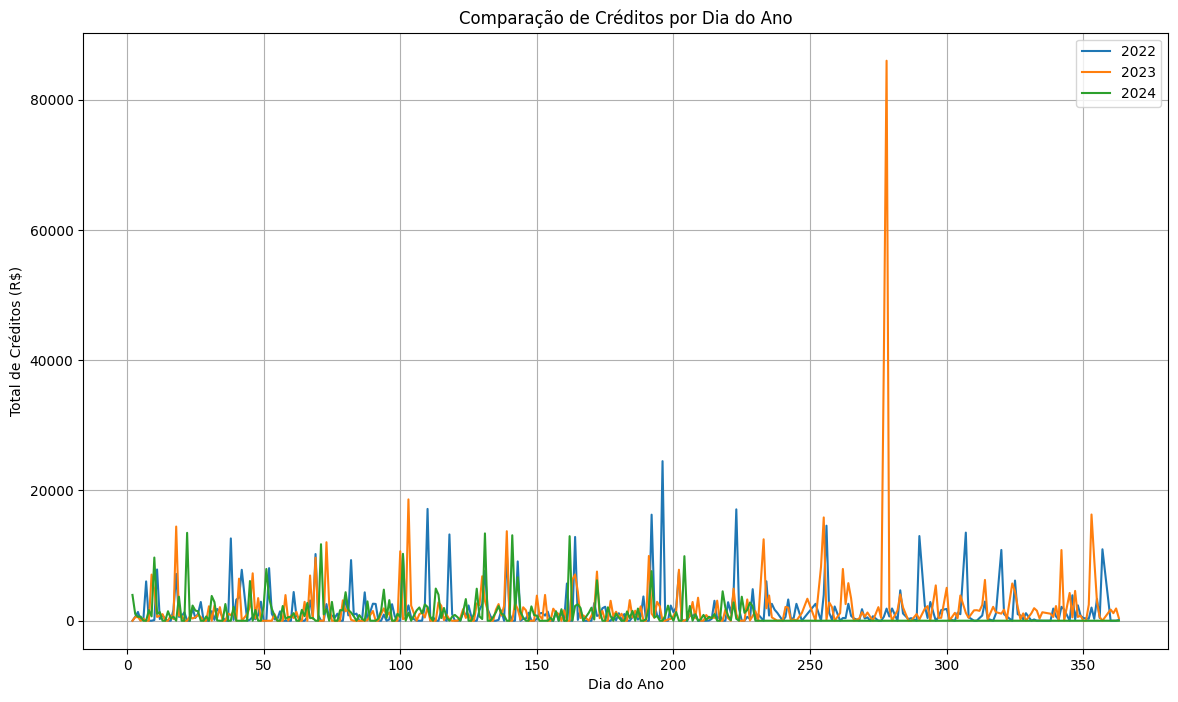

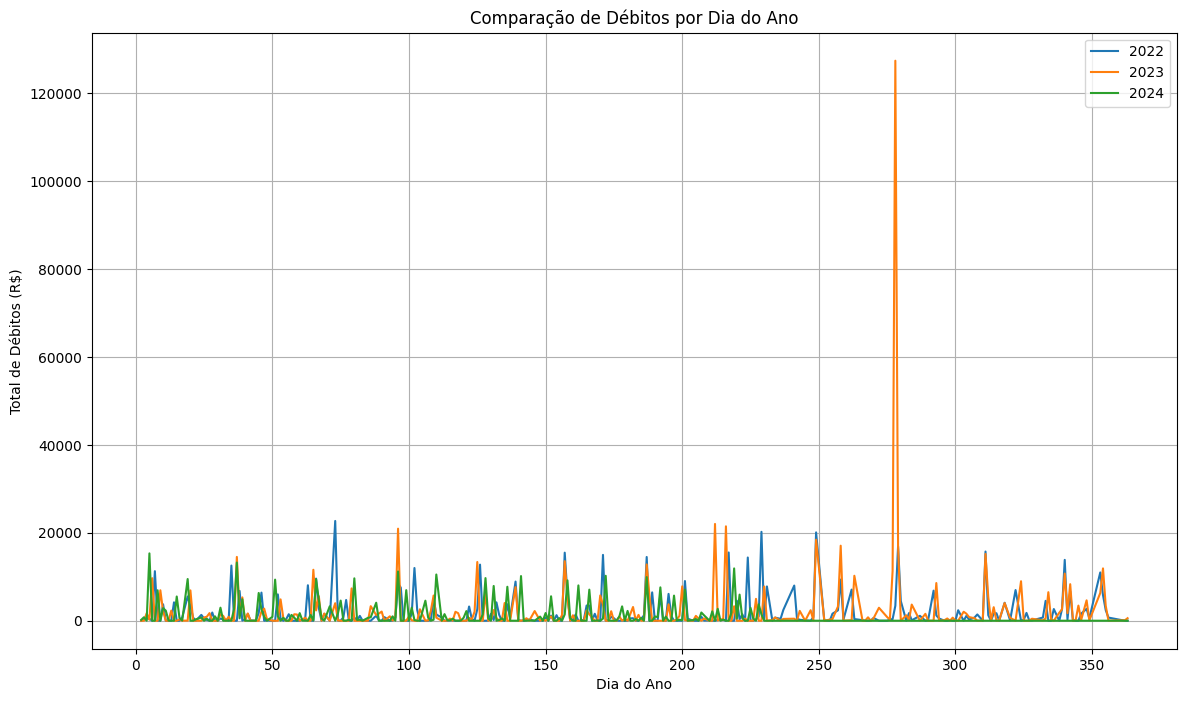

In [8]:
# Certificar-se de que a coluna 'date' é datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Criar uma função genérica para adicionar colunas derivadas
def preparar_dados(data, tipo):
    subset = data[data['type'] == tipo].copy()
    subset['day_of_year'] = subset['date'].dt.dayofyear
    return subset

# Preparar dados de crédito e débito
credito = preparar_dados(df, 'CREDITO')
debito = preparar_dados(df, 'DEBITO')

# Função para agrupar e pivotar por dia do ano e ano
def agrupar_e_pivotar(data, valor_col):
    agrupados = data.groupby(['day_of_year', 'year'])[valor_col].sum().reset_index()
    pivotados = agrupados.pivot(index='day_of_year', columns='year', values=valor_col).fillna(0)
    return pivotados

# Agregar e pivotar dados
credito_pivot = agrupar_e_pivotar(credito, 'value')
debito_pivot = agrupar_e_pivotar(debito, 'value')

# Função para plotar dados por ano
def plotar_por_ano(pivot_data, titulo, ylabel):
    plt.figure(figsize=(14, 8))
    for ano in pivot_data.columns:
        plt.plot(pivot_data.index, pivot_data[ano], label=str(ano))
    plt.title(titulo)
    plt.xlabel('Dia do Ano')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    plt.show()

# Plotar dados de créditos e débitos
plotar_por_ano(credito_pivot, 'Comparação de Créditos por Dia do Ano', 'Total de Créditos (R$)')
plotar_por_ano(debito_pivot, 'Comparação de Débitos por Dia do Ano', 'Total de Débitos (R$)')



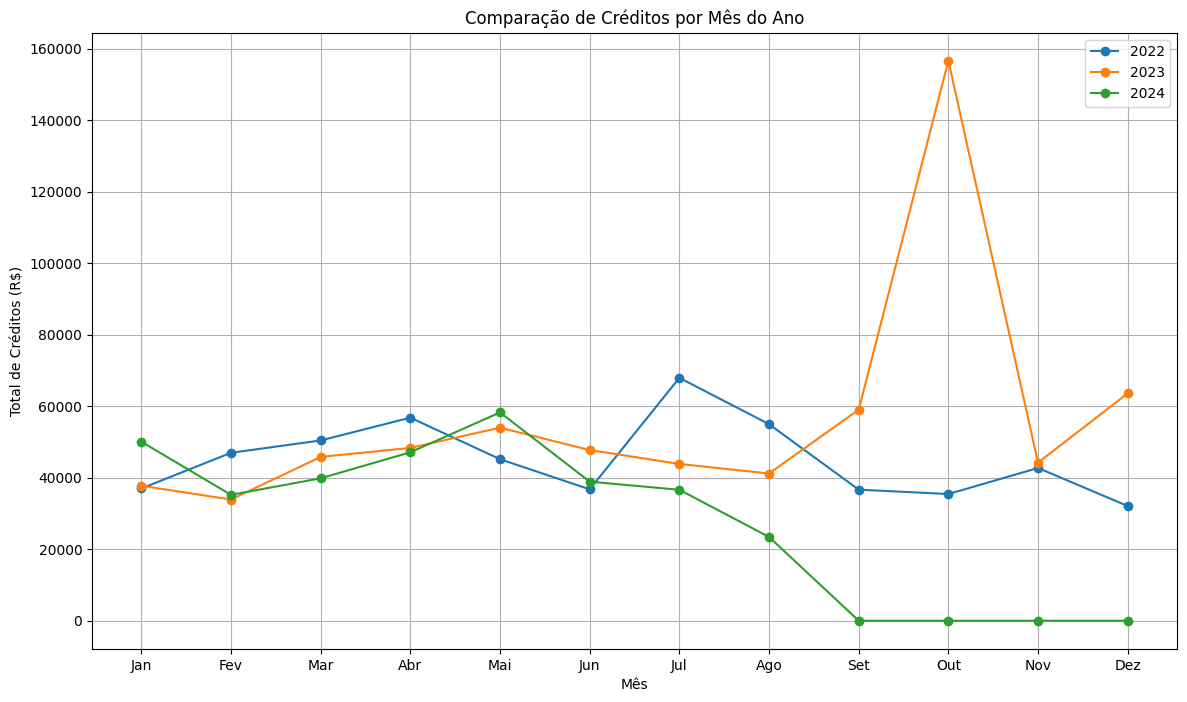

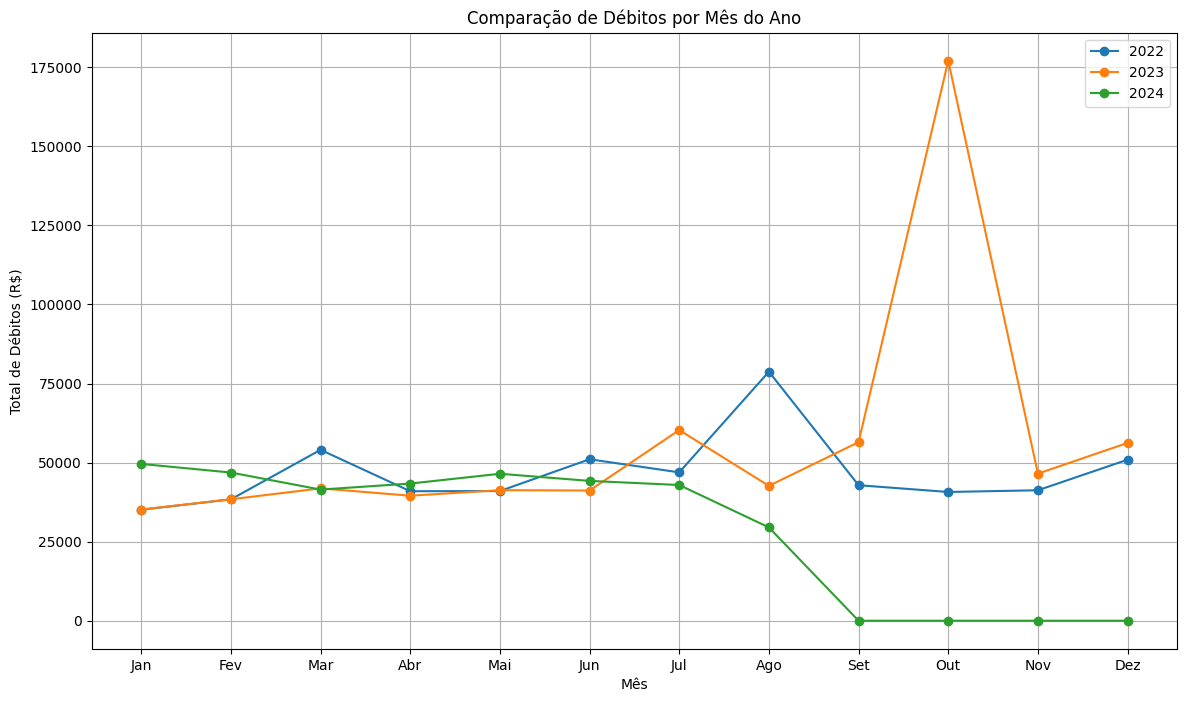

In [9]:
# Certificar-se de que a coluna 'date' é datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Criar uma função genérica para adicionar colunas derivadas
def preparar_dados(data, tipo):
    subset = data[data['type'] == tipo].copy()
    return subset

# Preparar dados de crédito e débito
credito = preparar_dados(df, 'CREDITO')
debito = preparar_dados(df, 'DEBITO')

# Função para agrupar e pivotar por mês e ano
def agrupar_e_pivotar_por_mes(data, valor_col):
    data['month'] = data['date'].dt.month
    data['year'] = data['date'].dt.year
    agrupados = data.groupby(['month', 'year'])[valor_col].sum().reset_index()
    pivotados = agrupados.pivot(index='month', columns='year', values=valor_col).fillna(0)
    return pivotados

# Agregar e pivotar dados
credito_pivot = agrupar_e_pivotar_por_mes(credito, 'value')
debito_pivot = agrupar_e_pivotar_por_mes(debito, 'value')

# Função para plotar dados por mês
def plotar_por_mes(pivot_data, titulo, ylabel):
    plt.figure(figsize=(14, 8))
    for ano in pivot_data.columns:
        plt.plot(pivot_data.index, pivot_data[ano], label=str(ano), marker='o')
    plt.title(titulo)
    plt.xlabel('Mês')
    plt.ylabel(ylabel)
    plt.xticks(range(1, 13), ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez'])
    plt.legend()
    plt.grid()
    plt.show()

# Plotar dados de créditos e débitos por mês
plotar_por_mes(credito_pivot, 'Comparação de Créditos por Mês do Ano', 'Total de Créditos (R$)')
plotar_por_mes(debito_pivot, 'Comparação de Débitos por Mês do Ano', 'Total de Débitos (R$)')

### Saldo

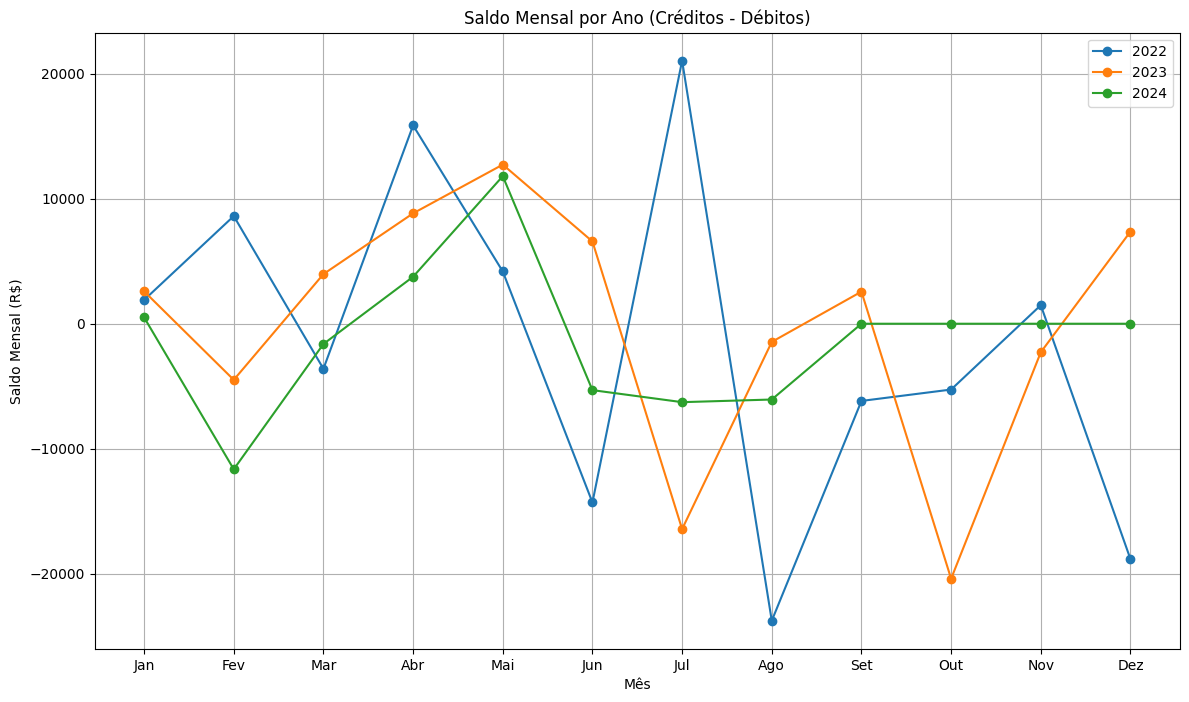

In [10]:
# Calcular o saldo mensal (Créditos - Débitos)
saldo_pivot = credito_pivot - debito_pivot

# Plotar o saldo mensal por ano
plotar_por_mes(saldo_pivot, 'Saldo Mensal por Ano (Créditos - Débitos)', 'Saldo Mensal (R$)')



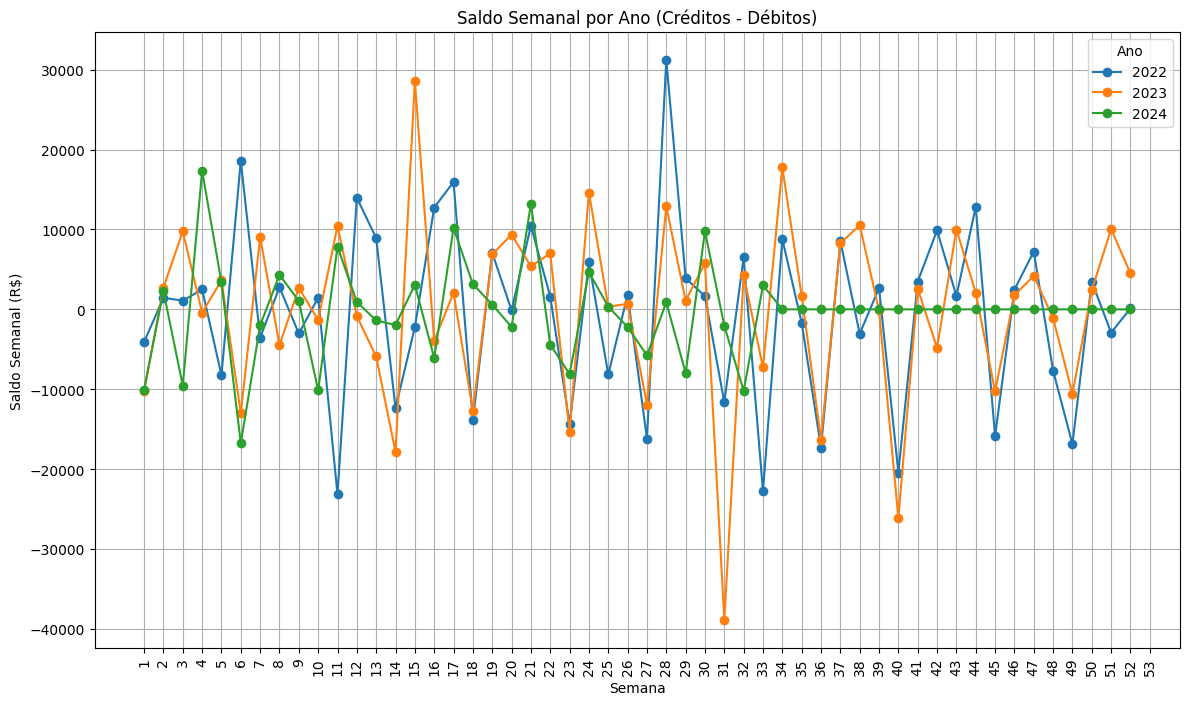

In [11]:
# Certificar-se de que a coluna 'date' é datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Criar colunas 'week' e 'year' para separação semanal
credito['week'] = credito['date'].dt.isocalendar().week
credito['year'] = credito['date'].dt.isocalendar().year
debito['week'] = debito['date'].dt.isocalendar().week
debito['year'] = debito['date'].dt.isocalendar().year

# Função para agrupar e pivotar por semana e ano
def agrupar_e_pivotar_por_semana(data, valor_col):
    agrupados = data.groupby(['week', 'year'])[valor_col].sum().reset_index()
    pivotados = agrupados.pivot(index='week', columns='year', values=valor_col).fillna(0)
    return pivotados

# Agregar e pivotar dados de crédito e débito semanalmente
credito_semanal = agrupar_e_pivotar_por_semana(credito, 'value')
debito_semanal = agrupar_e_pivotar_por_semana(debito, 'value')

# Calcular saldo semanal
saldo_semanal = credito_semanal - debito_semanal

# Função para plotar dados por semana
def plotar_por_semana(pivot_data, titulo, ylabel):
    plt.figure(figsize=(14, 8))
    for ano in pivot_data.columns:
        plt.plot(pivot_data.index, pivot_data[ano], label=str(ano), marker='o')
    plt.title(titulo)
    plt.xlabel('Semana')
    plt.ylabel(ylabel)
    plt.xticks(range(1, 54), range(1, 54), rotation=90)
    plt.legend(title='Ano')
    plt.grid()
    plt.show()

# Plotar saldo semanal por ano
plotar_por_semana(saldo_semanal, 'Saldo Semanal por Ano (Créditos - Débitos)', 'Saldo Semanal (R$)')


**Variável Dependente (Y):**
O saldo total calculado em intervalos regulares, como valores mensais e semanais.

**Variável Independente (X):**
O histórico dos valores observados na série temporal, considerando apenas os dados endógenos, sem a inclusão de variáveis externas.

## SARIMA

Saldo Mensal

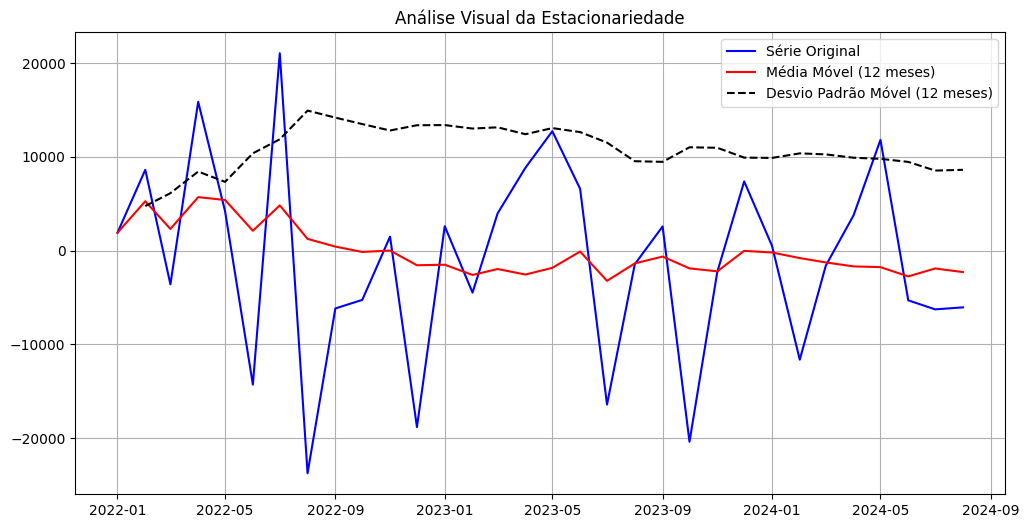


Teste de Dickey-Fuller Aumentado:
Estatística de Teste: -6.5134
Valor-p: 0.0000
Valores Críticos:
   1%: -3.6614
   5%: -2.9605
   10%: -2.6193


In [12]:
from statsmodels.tsa.stattools import adfuller
# Certificar-se de que a coluna 'date' é datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Filtrar os dados entre janeiro de 2022 e agosto de 2024
df_filtered = df[(df['date'] >= '2022-01-01') & (df['date'] < '2024-09-01')]

# Calcular o saldo mensal
df_filtered['month'] = df_filtered['date'].dt.to_period('M')
saldo_mensal = (
    df_filtered.groupby(['month', 'type'])['value']
    .sum()
    .unstack(fill_value=0)
)
saldo_mensal['saldo'] = saldo_mensal.get('CREDITO', 0) - saldo_mensal.get('DEBITO', 0)
saldo_mensal = saldo_mensal['saldo']  # Selecionar apenas a coluna saldo
saldo_mensal.index = saldo_mensal.index.to_timestamp()  # Converter o índice para timestamps

# Função aprimorada para verificar a estacionariedade da série
# Função aprimorada para verificar a estacionariedade da série
def testar_estacionariedade(serie, janela=12):
    """
    Testa a estacionariedade de uma série temporal com o teste de Dickey-Fuller
    e exibe gráficos auxiliares para análise visual.

    Args:
        serie (pd.Series): A série temporal a ser testada.
        janela (int): O tamanho da janela para a média móvel (default = 12).
    """
    # Cálculo de médias móveis
    media_movel = serie.rolling(window=janela, min_periods=1).mean()
    desvio_movel = serie.rolling(window=janela, min_periods=1).std()

    # Plotando a série original com médias móveis
    plt.figure(figsize=(12, 6))
    plt.plot(serie, color='blue', label='Série Original')
    plt.plot(media_movel, color='red', label=f'Média Móvel ({janela} meses)')
    plt.plot(desvio_movel, color='black', linestyle='--', label=f'Desvio Padrão Móvel ({janela} meses)')
    plt.title('Análise Visual da Estacionariedade')
    plt.legend()
    plt.grid()
    plt.show()

    # Aplicando o teste de Dickey-Fuller Aumentado
    print("\nTeste de Dickey-Fuller Aumentado:")
    resultado = adfuller(serie.dropna())
    print(f"Estatística de Teste: {resultado[0]:.4f}")
    print(f"Valor-p: {resultado[1]:.4f}")
    print("Valores Críticos:")
    for key, value in resultado[4].items():
        print(f"   {key}: {value:.4f}")

    # Retornar o valor-p para análise adicional
    return resultado[1]

# Aplicar o teste na série mensal de saldo
p_valor = testar_estacionariedade(saldo_mensal)




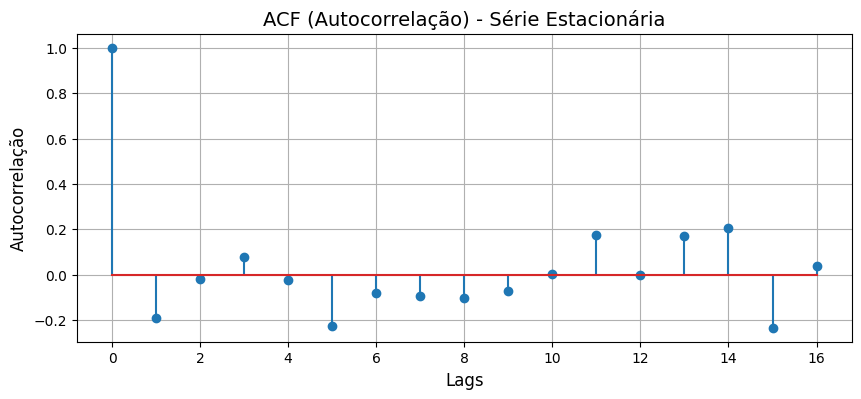

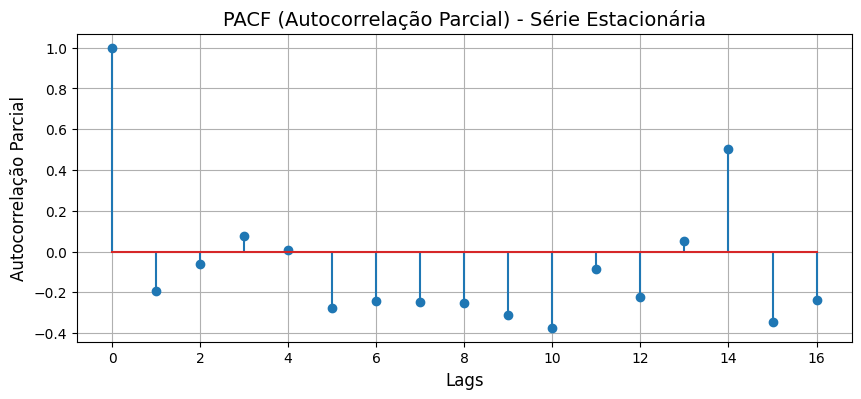

In [13]:
from statsmodels.graphics.tsaplots import acf, pacf

# Selecionar a série de saldo mensal já processada
series_to_analyze = saldo_mensal

# Determinar o número máximo de lags permitido
max_lags = len(series_to_analyze) // 2

# Calcular ACF e PACF com o número máximo de lags permitido
acf_values = acf(series_to_analyze, nlags=max_lags)
pacf_values = pacf(series_to_analyze, nlags=max_lags)

# Plotar ACF (Autocorrelação)
plt.figure(figsize=(10, 4))
plt.stem(range(len(acf_values)), acf_values)
plt.title("ACF (Autocorrelação) - Série Estacionária", fontsize=14)
plt.xlabel("Lags", fontsize=12)
plt.ylabel("Autocorrelação", fontsize=12)
plt.grid()
plt.show()

# Plotar PACF (Autocorrelação Parcial)
plt.figure(figsize=(10, 4))
plt.stem(range(len(pacf_values)), pacf_values)
plt.title("PACF (Autocorrelação Parcial) - Série Estacionária", fontsize=14)
plt.xlabel("Lags", fontsize=12)
plt.ylabel("Autocorrelação Parcial", fontsize=12)
plt.grid()
plt.show()


                                     SARIMAX Results                                      
Dep. Variable:                              saldo   No. Observations:                   24
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                   0.000
Date:                            Tue, 26 Nov 2024   AIC                             10.000
Time:                                    15:38:21   BIC                                nan
Sample:                                01-01-2022   HQIC                               nan
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2072         -0        inf      0.000      -0.207      -0.207
ma.L1         -1.2723         -0   

/home/corisco/cesar.school/dash/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/corisco/cesar.school/dash/venv/lib/python3.12/site-packages/statsmodels/tools/eval_measures.py:414: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
/home/corisco/cesar.school/dash/venv/lib/python3.12/site-packages/statsmodels/tools/eval_measures.py:439: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
/home/corisco/cesar.school/dash/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
/home/corisco/cesar.school/dash/venv/lib/python3.12/site-packages/sta

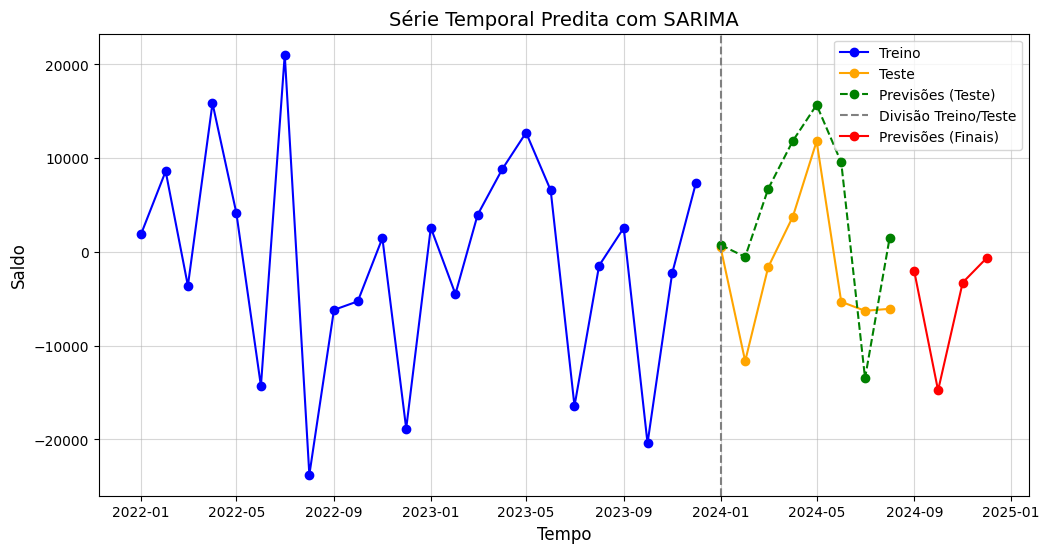

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

# **1. Dividir os Dados em Treino e Teste**
# Usar os últimos 8 meses como teste
train_data = saldo_mensal[:-8]
test_data = saldo_mensal[-8:]

# **2. Ajustar o Modelo SARIMA**
p, d, q = 1, 1, 1  # Componentes regulares
P, D, Q, m = 1, 1, 1, 12  # Componentes sazonais (mensalidade = 12)

model = SARIMAX(train_data, 
                order=(p, d, q), 
                seasonal_order=(P, D, Q, m), 
                enforce_stationarity=False, 
                enforce_invertibility=False)

model_fit = model.fit(disp=False)

# Exibir o resumo do modelo ajustado
print(model_fit.summary())

# **3. Avaliar o Modelo**
# Fazer previsões para os dados de teste
predictions = model_fit.forecast(steps=len(test_data))

# Calcular métricas de erro
mae = mean_absolute_error(test_data, predictions)
mse = mean_squared_error(test_data, predictions)

print("\nAvaliação do Modelo SARIMA:")
print(f"Erro Absoluto Médio (MAE): {mae:.4f}")
print(f"Erro Médio Quadrático (MSE): {mse:.4f}")

# **4. Fazer Previsões Finais para Setembro-Dezembro de 2024**
# Ajustar o modelo em todos os dados disponíveis
final_model = SARIMAX(saldo_mensal, 
                      order=(p, d, q), 
                      seasonal_order=(P, D, Q, m), 
                      enforce_stationarity=False, 
                      enforce_invertibility=False)

final_model_fit = final_model.fit(disp=False)

# Prever os próximos 4 meses
final_predictions = final_model_fit.forecast(steps=4)

# Exibir previsões finais
print("\nPrevisões para Setembro-Dezembro de 2024:")
print(final_predictions)

# **5. Plotar os Resultados**
# Gráfico dos dados de treino, teste e previsões
plt.figure(figsize=(12, 6))
plt.plot(train_data, label="Treino", color="blue", marker='o')
plt.plot(test_data, label="Teste", color="orange", marker='o')
plt.plot(predictions, label="Previsões (Teste)", color="green", linestyle="--", marker='o')
plt.axvline(test_data.index[0], color="gray", linestyle="--", label="Divisão Treino/Teste")

# Adicionar previsões finais
plt.plot(final_predictions.index, final_predictions, label="Previsões (Finais)", color="red", marker='o')

plt.title("Série Temporal Predita com SARIMA", fontsize=14)
plt.xlabel("Tempo", fontsize=12)
plt.ylabel("Saldo", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.5)
plt.show()


Saldo Semanal

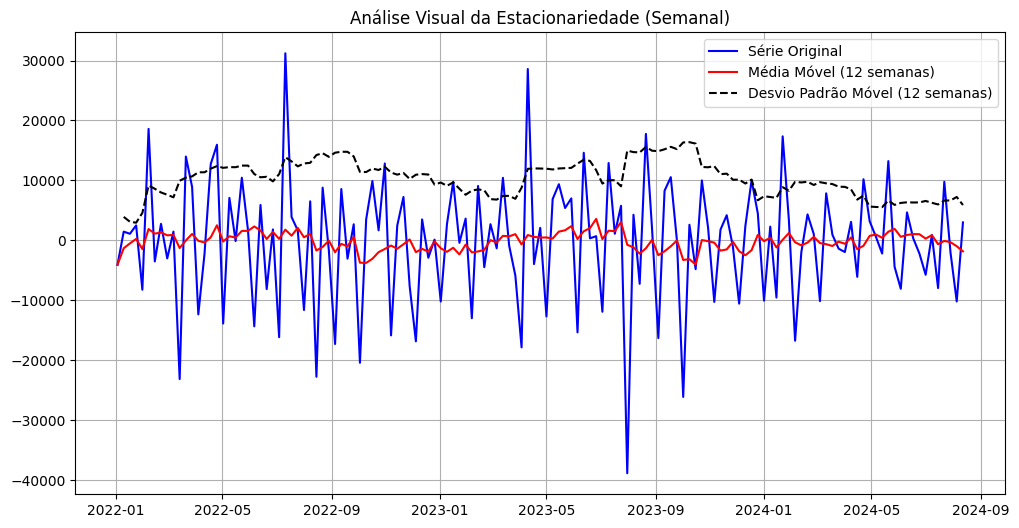


Teste de Dickey-Fuller Aumentado:
Estatística de Teste: -3.1913
Valor-p: 0.0205
Valores Críticos:
   1%: -3.4842
   5%: -2.8851
   10%: -2.5794


In [15]:
from statsmodels.tsa.stattools import adfuller

# Certificar-se de que a coluna 'date' é datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Filtrar os dados entre janeiro de 2022 e agosto de 2024
df_filtered = df[(df['date'] >= '2022-01-01') & (df['date'] < '2024-09-01')]

# Calcular o saldo semanal
df_filtered['week'] = df_filtered['date'].dt.to_period('W')
saldo_semanal = (
    df_filtered.groupby(['week', 'type'])['value']
    .sum()
    .unstack(fill_value=0)
)
saldo_semanal['saldo'] = saldo_semanal.get('CREDITO', 0) - saldo_semanal.get('DEBITO', 0)
saldo_semanal = saldo_semanal['saldo']  # Selecionar apenas a coluna saldo
saldo_semanal.index = saldo_semanal.index.to_timestamp()  # Converter o índice para timestamps

# Função aprimorada para verificar a estacionariedade da série
def testar_estacionariedade(serie, janela=12):
    """
    Testa a estacionariedade de uma série temporal com o teste de Dickey-Fuller
    e exibe gráficos auxiliares para análise visual.

    Args:
        serie (pd.Series): A série temporal a ser testada.
        janela (int): O tamanho da janela para a média móvel (default = 12).
    """
    # Cálculo de médias móveis
    media_movel = serie.rolling(window=janela, min_periods=1).mean()
    desvio_movel = serie.rolling(window=janela, min_periods=1).std()

    # Plotando a série original com médias móveis
    plt.figure(figsize=(12, 6))
    plt.plot(serie, color='blue', label='Série Original')
    plt.plot(media_movel, color='red', label=f'Média Móvel ({janela} semanas)')
    plt.plot(desvio_movel, color='black', linestyle='--', label=f'Desvio Padrão Móvel ({janela} semanas)')
    plt.title('Análise Visual da Estacionariedade (Semanal)')
    plt.legend()
    plt.grid()
    plt.show()

    # Aplicando o teste de Dickey-Fuller Aumentado
    print("\nTeste de Dickey-Fuller Aumentado:")
    resultado = adfuller(serie.dropna())
    print(f"Estatística de Teste: {resultado[0]:.4f}")
    print(f"Valor-p: {resultado[1]:.4f}")
    print("Valores Críticos:")
    for key, value in resultado[4].items():
        print(f"   {key}: {value:.4f}")

    # Retornar o valor-p para análise adicional
    return resultado[1]

# Aplicar o teste na série semanal de saldo
p_valor = testar_estacionariedade(saldo_semanal)


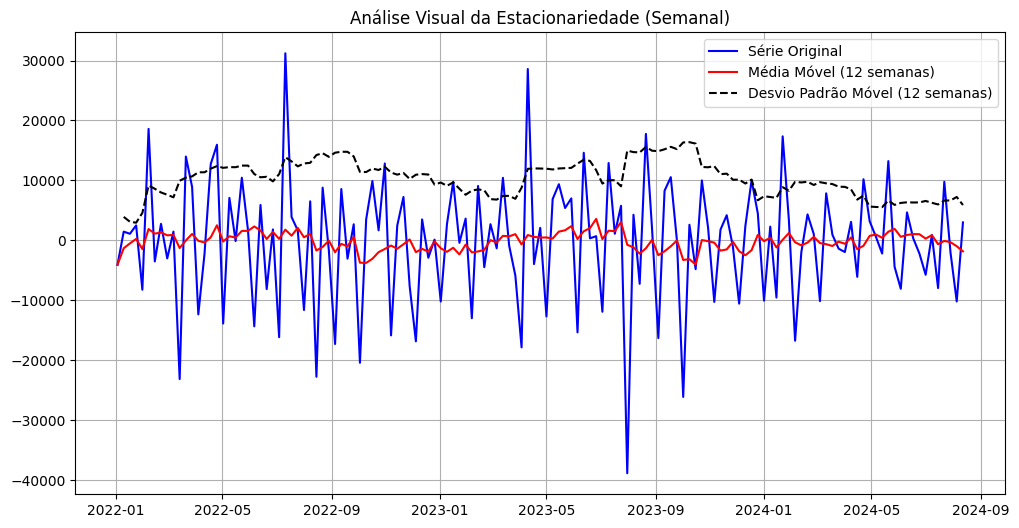


Análise Visual da Estacionariedade (Semanal) - Teste de Dickey-Fuller Aumentado:
Estatística de Teste: -3.1913
Valor-p: 0.0205
Valores Críticos:
   1%: -3.4842
   5%: -2.8851
   10%: -2.5794


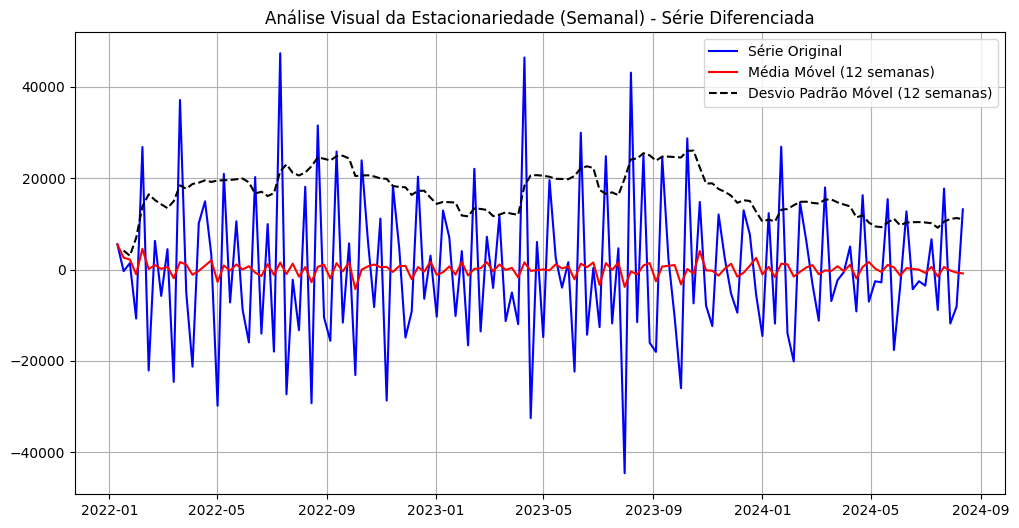


Análise Visual da Estacionariedade (Semanal) - Série Diferenciada - Teste de Dickey-Fuller Aumentado:
Estatística de Teste: -5.9856
Valor-p: 0.0000
Valores Críticos:
   1%: -3.4851
   5%: -2.8855
   10%: -2.5796


In [16]:
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# Certificar-se de que a coluna 'date' é datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Filtrar os dados entre janeiro de 2022 e agosto de 2024
df_filtered = df[(df['date'] >= '2022-01-01') & (df['date'] < '2024-09-01')]

# Calcular o saldo semanal
df_filtered['week'] = df_filtered['date'].dt.to_period('W')
saldo_semanal = (
    df_filtered.groupby(['week', 'type'])['value']
    .sum()
    .unstack(fill_value=0)
)
saldo_semanal['saldo'] = saldo_semanal.get('CREDITO', 0) - saldo_semanal.get('DEBITO', 0)
saldo_semanal = saldo_semanal['saldo']  # Selecionar apenas a coluna saldo
saldo_semanal.index = saldo_semanal.index.to_timestamp()  # Converter o índice para timestamps

# Função aprimorada para verificar a estacionariedade da série
def testar_estacionariedade(serie, janela=12, titulo=''):
    """
    Testa a estacionariedade de uma série temporal com o teste de Dickey-Fuller
    e exibe gráficos auxiliares para análise visual.

    Args:
        serie (pd.Series): A série temporal a ser testada.
        janela (int): O tamanho da janela para a média móvel (default = 12).
        titulo (str): Título do gráfico.
    """
    # Cálculo de médias móveis
    media_movel = serie.rolling(window=janela, min_periods=1).mean()
    desvio_movel = serie.rolling(window=janela, min_periods=1).std()

    # Plotando a série original com médias móveis
    plt.figure(figsize=(12, 6))
    plt.plot(serie, color='blue', label='Série Original')
    plt.plot(media_movel, color='red', label=f'Média Móvel ({janela} semanas)')
    plt.plot(desvio_movel, color='black', linestyle='--', label=f'Desvio Padrão Móvel ({janela} semanas)')
    plt.title(titulo)
    plt.legend()
    plt.grid()
    plt.show()

    # Aplicando o teste de Dickey-Fuller Aumentado
    print(f"\n{titulo} - Teste de Dickey-Fuller Aumentado:")
    resultado = adfuller(serie.dropna())
    print(f"Estatística de Teste: {resultado[0]:.4f}")
    print(f"Valor-p: {resultado[1]:.4f}")
    print("Valores Críticos:")
    for key, value in resultado[4].items():
        print(f"   {key}: {value:.4f}")

    # Retornar o valor-p para análise adicional
    return resultado[1]

# Aplicar o teste e plotar a série original
p_valor_original = testar_estacionariedade(saldo_semanal, titulo="Análise Visual da Estacionariedade (Semanal)")

# Aplicar a primeira diferenciação
saldo_semanal_diff = saldo_semanal.diff().dropna()

# Aplicar o teste e plotar a série diferenciada
p_valor_diferenciada = testar_estacionariedade(saldo_semanal_diff, titulo="Análise Visual da Estacionariedade (Semanal) - Série Diferenciada")


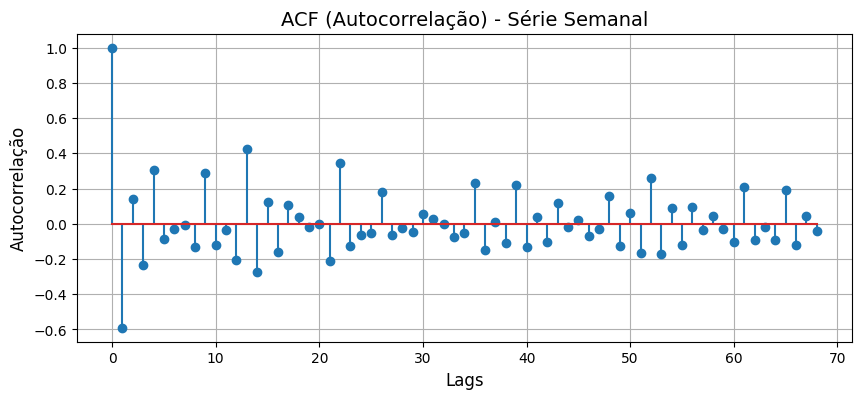

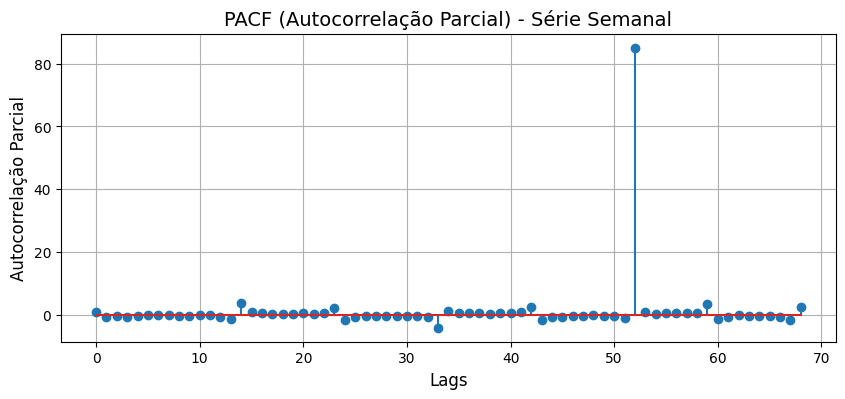

In [17]:
from statsmodels.graphics.tsaplots import acf, pacf

# Selecionar a série de saldo semanal já processada
series_to_analyze = saldo_semanal_diff

# Determinar o número máximo de lags permitido
max_lags = len(series_to_analyze) // 2

# Calcular ACF e PACF com o número máximo de lags permitido
acf_values = acf(series_to_analyze, nlags=max_lags)
pacf_values = pacf(series_to_analyze, nlags=max_lags)

# Plotar ACF (Autocorrelação)
plt.figure(figsize=(10, 4))
plt.stem(range(len(acf_values)), acf_values)
plt.title("ACF (Autocorrelação) - Série Semanal", fontsize=14)
plt.xlabel("Lags", fontsize=12)
plt.ylabel("Autocorrelação", fontsize=12)
plt.grid()
plt.show()

# Plotar PACF (Autocorrelação Parcial)
plt.figure(figsize=(10, 4))
plt.stem(range(len(pacf_values)), pacf_values)
plt.title("PACF (Autocorrelação Parcial) - Série Semanal", fontsize=14)
plt.xlabel("Lags", fontsize=12)
plt.ylabel("Autocorrelação Parcial", fontsize=12)
plt.grid()
plt.show()


/home/corisco/cesar.school/dash/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/corisco/cesar.school/dash/venv/lib/python3.12/site-packages/statsmodels/tools/eval_measures.py:414: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + np.log(nobs) * df_modelwc
/home/corisco/cesar.school/dash/venv/lib/python3.12/site-packages/statsmodels/tools/eval_measures.py:439: RuntimeWarning: invalid value encountered in log
  return -2.0 * llf + 2 * np.log(np.log(nobs)) * df_modelwc
/home/corisco/cesar.school/dash/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse
/home/corisco/cesar.school/dash/venv/lib/python3.12/site-packages/sta

                                     SARIMAX Results                                      
Dep. Variable:                              saldo   No. Observations:                  104
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood                   0.000
Date:                            Tue, 26 Nov 2024   AIC                             10.000
Time:                                    15:47:24   BIC                                nan
Sample:                                01-03-2022   HQIC                               nan
                                     - 12-25-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0975         -0        inf      0.000      -0.097      -0.097
ma.L1         -0.8627         -0   

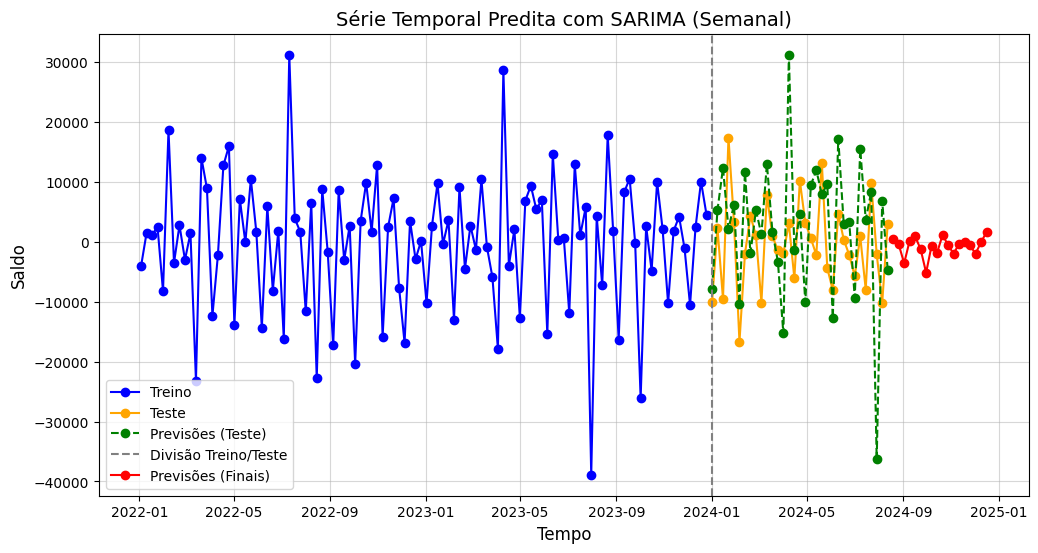

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# **1. Dividir os Dados em Treino e Teste**
# Certificar-se de que saldo_semanal existe e está bem definido
if 'saldo_semanal' not in locals():
    print("Erro: A variável 'saldo_semanal' não está definida. Certifique-se de que ela foi criada corretamente.")

# Filtrar treino: janeiro de 2022 até dezembro de 2023
train_data = saldo_semanal[:'2023-12-31']

# Filtrar teste: janeiro de 2024 até agosto de 2024
test_data = saldo_semanal['2024-01-01':'2024-08-31']

# **2. Ajustar o Modelo SARIMA**
# Definir os parâmetros do modelo
p, d, q = 1, 1, 1  # Componentes regulares
P, D, Q, m = 1, 1, 1, 52  # Componentes sazonais (semanalidade = 52 semanas)

# Ajustar o modelo SARIMA com os dados de treino
model = SARIMAX(train_data, 
                order=(p, d, q), 
                seasonal_order=(P, D, Q, m), 
                enforce_stationarity=False, 
                enforce_invertibility=False)

try:
    model_fit = model.fit(disp=False)
    # Exibir o resumo do modelo ajustado
    print(model_fit.summary())
except Exception as e:
    print("Erro ao ajustar o modelo SARIMA:", e)

# **3. Avaliar o Modelo**
try:
    # Fazer previsões para os dados de teste
    predictions = model_fit.forecast(steps=len(test_data))
    
    # Calcular métricas de erro
    mae = mean_absolute_error(test_data, predictions)
    mse = mean_squared_error(test_data, predictions)

    print("\nAvaliação do Modelo SARIMA:")
    print(f"Erro Absoluto Médio (MAE): {mae:.4f}")
    print(f"Erro Médio Quadrático (MSE): {mse:.4f}")
except Exception as e:
    print("Erro ao avaliar o modelo SARIMA:", e)

# **4. Fazer Previsões Finais para setembro a dezembro de 2024**
try:
    # Ajustar o modelo em todos os dados disponíveis (até agosto de 2024)
    final_model = SARIMAX(saldo_semanal, 
                          order=(p, d, q), 
                          seasonal_order=(P, D, Q, m), 
                          enforce_stationarity=False, 
                          enforce_invertibility=False)

    final_model_fit = final_model.fit(disp=False)

    # Prever as próximas 18 semanas (setembro a dezembro de 2024)
    final_predictions = final_model_fit.forecast(steps=18)

    # Exibir previsões finais
    print("\nPrevisões para setembro a dezembro de 2024:")
    print(final_predictions)
except Exception as e:
    print("Erro ao ajustar o modelo final SARIMA:", e)

# **5. Plotar os Resultados**
try:
    plt.figure(figsize=(12, 6))
    plt.plot(train_data, label="Treino", color="blue", marker='o')
    plt.plot(test_data, label="Teste", color="orange", marker='o')
    plt.plot(predictions, label="Previsões (Teste)", color="green", linestyle="--", marker='o')
    plt.axvline(test_data.index[0], color="gray", linestyle="--", label="Divisão Treino/Teste")

    # Adicionar previsões finais
    plt.plot(final_predictions.index, final_predictions, label="Previsões (Finais)", color="red", marker='o')

    plt.title("Série Temporal Predita com SARIMA (Semanal)", fontsize=14)
    plt.xlabel("Tempo", fontsize=12)
    plt.ylabel("Saldo", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.5)
    plt.show()
except Exception as e:
    print("Erro ao plotar os resultados:", e)


In [28]:
import pandas as pd

def realizar_testes_dados(df):
    """
    Realiza testes e validações nos dados, incluindo análise de tipos,
    soma total de valores, soma por tipo e cálculo do saldo.
    
    Args:
        df (pd.DataFrame): DataFrame contendo os dados transacionais.
    
    Returns:
        None: Exibe os resultados no console ou interface.
    """
    print("\n=== Testes de Dados Transacionais ===\n")

    # 1. Quantidade de tipos únicos na coluna 'type'
    print("Tipos únicos na coluna 'type':")
    tipos_unicos = df['type'].unique()
    print(tipos_unicos)

    # 2. Quantidade de transações por tipo
    print("\nContagem de transações por tipo:")
    contagem_tipos = df['type'].value_counts()
    print(contagem_tipos)

    # 3. Soma total de valores
    soma_total = df['value'].sum()
    print(f"\nSoma total de todos os valores: R$ {soma_total:,.2f}")

    # 4. Soma total por tipo ('CREDITO', 'DEBITO', ou outros)
    print("\nSoma total por tipo:")
    soma_por_tipo = df.groupby('type')['value'].sum()
    print(soma_por_tipo)

    # 5. Cálculo do saldo (CREDITO - DEBITO)
    credito_total = soma_por_tipo.get('CREDITO', 0)
    debito_total = soma_por_tipo.get('DEBITO', 0)
    saldo = credito_total - debito_total

    print(f"\nSoma total de CREDITO: R$ {credito_total:,.2f}")
    print(f"Soma total de DEBITO: R$ {debito_total:,.2f}")
    print(f"Saldo total (CREDITO - DEBITO): R$ {saldo:,.2f}")

    # 6. Verificar valores nulos
    print("\nValores nulos por coluna:")
    valores_nulos = df.isnull().sum()
    print(valores_nulos)

    # 7. Verificar se há valores negativos no tipo 'CREDITO' e valores positivos no tipo 'DEBITO'
    print("\nVerificando inconsistências nos valores:")
    credito_negativo = df[(df['type'] == 'CREDITO') & (df['value'] < 0)]
    debito_positivo = df[(df['type'] == 'DEBITO') & (df['value'] > 0)]

    print(f"Transações de CREDITO com valores negativos: {len(credito_negativo)}")
    if not credito_negativo.empty:
        print(credito_negativo)

    print(f"Transações de DEBITO com valores positivos: {len(debito_positivo)}")
    if not debito_positivo.empty:
        print(debito_positivo)

    print("\n=== Fim dos Testes ===\n")

realizar_testes_dados(df)



=== Testes de Dados Transacionais ===

Tipos únicos na coluna 'type':
['CREDITO' 'DEBITO']

Contagem de transações por tipo:
type
DEBITO     1856
CREDITO    1665
Name: count, dtype: int64

Soma total de todos os valores: R$ 3,131,506.27

Soma total por tipo:
type
CREDITO    1548704.48
DEBITO     1582801.79
Name: value, dtype: float64

Soma total de CREDITO: R$ 1,548,704.48
Soma total de DEBITO: R$ 1,582,801.79
Saldo total (CREDITO - DEBITO): R$ -34,097.31

Valores nulos por coluna:
id                   0
date                 0
type                 0
description          0
payment_method       0
bank                 0
value                0
categories           1
notes             2011
month                0
year                 0
dtype: int64

Verificando inconsistências nos valores:
Transações de CREDITO com valores negativos: 0
Transações de DEBITO com valores positivos: 1856
          id       date    type                           description  \
2          3 2024-01-05  DEBITO   E

/home/corisco/cesar.school/dash/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                     SARIMAX Results                                      
Dep. Variable:                              saldo   No. Observations:                  103
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 52)   Log Likelihood                -523.430
Date:                            Tue, 26 Nov 2024   AIC                           1056.859
Time:                                    15:47:28   BIC                           1066.318
Sample:                                01-10-2022   HQIC                          1060.448
                                     - 12-25-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2675      0.354     -0.756      0.450      -0.961       0.426
ma.L1         -0.9832      0.289   

/home/corisco/cesar.school/dash/venv/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'



Previsões para setembro a dezembro de 2024 (Série Diferenciada):
2024-08-19     975.675094
2024-08-26   -3210.159654
2024-09-02   -5027.724909
2024-09-09    6066.832872
2024-09-16    1774.565744
2024-09-23   -4095.840532
2024-09-30   -6694.147236
2024-10-07    7549.248285
2024-10-14   -3057.938398
2024-10-21    5712.919481
2024-10-28   -3647.463188
2024-11-04   -1624.255269
2024-11-11    2429.591899
2024-11-18     380.623068
2024-11-25    -465.588591
2024-12-02   -2367.572251
2024-12-09    2559.148803
2024-12-16    3141.937314
Freq: W-MON, Name: predicted_mean, dtype: float64


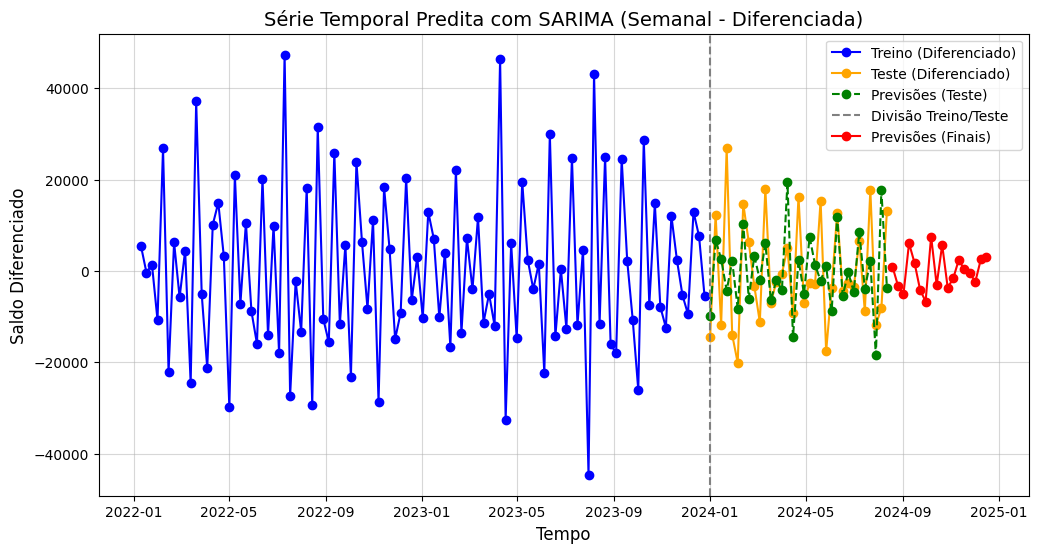

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# **1. Dividir os Dados em Treino e Teste**
# Usar a série diferenciada
train_data = saldo_semanal_diff[:'2023-12-31']
test_data = saldo_semanal_diff['2024-01-01':'2024-08-31']

# **2. Ajustar o Modelo SARIMA**
# Ajustar os parâmetros para refletir a diferenciação manual
p, d, q = 1, 0, 1  # 'd=0' porque a diferenciação foi aplicada manualmente
P, D, Q, m = 1, 0, 1, 52  # 'D=0' porque a diferenciação sazonal foi aplicada manualmente

# Ajustar o modelo SARIMA com os dados de treino diferenciados
model = SARIMAX(train_data,
                order=(p, d, q),
                seasonal_order=(P, D, Q, m),
                enforce_stationarity=False,
                enforce_invertibility=False)

try:
    model_fit = model.fit(disp=False)
    # Exibir o resumo do modelo ajustado
    print(model_fit.summary())
except Exception as e:
    print("Erro ao ajustar o modelo SARIMA:", e)

# **3. Avaliar o Modelo**
try:
    # Fazer previsões para os dados de teste
    predictions = model_fit.forecast(steps=len(test_data))

    # Calcular métricas de erro
    mae = mean_absolute_error(test_data, predictions)
    mse = mean_squared_error(test_data, predictions)

    print("\nAvaliação do Modelo SARIMA:")
    print(f"Erro Absoluto Médio (MAE): {mae:.4f}")
    print(f"Erro Médio Quadrático (MSE): {mse:.4f}")
except Exception as e:
    print("Erro ao avaliar o modelo SARIMA:", e)

# **4. Fazer Previsões Finais para setembro a dezembro de 2024**
try:
    # Ajustar o modelo em todos os dados disponíveis (até agosto de 2024)
    final_model = SARIMAX(saldo_semanal_diff,
                          order=(p, d, q),
                          seasonal_order=(P, D, Q, m),
                          enforce_stationarity=False,
                          enforce_invertibility=False)

    final_model_fit = final_model.fit(disp=False)

    # Prever as próximas 18 semanas (setembro a dezembro de 2024)
    final_predictions = final_model_fit.forecast(steps=18)

    # Exibir previsões finais
    print("\nPrevisões para setembro a dezembro de 2024 (Série Diferenciada):")
    print(final_predictions)
except Exception as e:
    print("Erro ao ajustar o modelo final SARIMA:", e)

# **5. Plotar os Resultados**
try:
    plt.figure(figsize=(12, 6))
    plt.plot(train_data, label="Treino (Diferenciado)", color="blue", marker='o')
    plt.plot(test_data, label="Teste (Diferenciado)", color="orange", marker='o')
    plt.plot(predictions, label="Previsões (Teste)", color="green", linestyle="--", marker='o')
    plt.axvline(test_data.index[0], color="gray", linestyle="--", label="Divisão Treino/Teste")

    # Adicionar previsões finais
    plt.plot(final_predictions.index, final_predictions, label="Previsões (Finais)", color="red", marker='o')

    plt.title("Série Temporal Predita com SARIMA (Semanal - Diferenciada)", fontsize=14)
    plt.xlabel("Tempo", fontsize=12)
    plt.ylabel("Saldo Diferenciado", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.5)
    plt.show()
except Exception as e:
    print("Erro ao plotar os resultados:", e)
